# Classification of Cancer by Gene Expression

The dataset showes how new cases of cancer could be classified by gene expression monitoring (via DNA microarray) and thereby provided a general approach for identifying new cancer classes and assigning tumors to known classes. These data were used to classify patients with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).

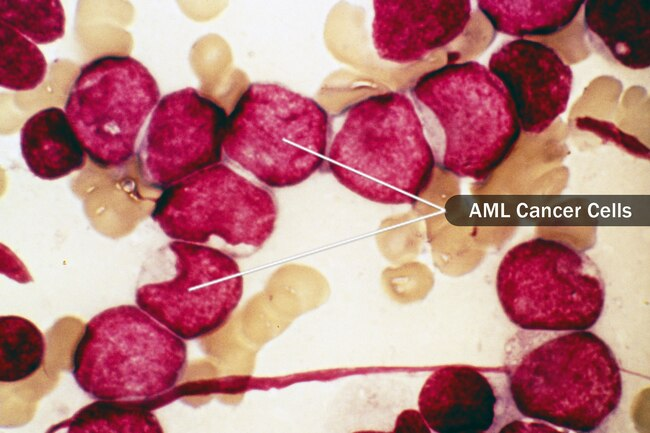

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Load all the required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score, precision_score, classification_report,accuracy_score,confusion_matrix, roc_curve, auc, roc_curve,accuracy_score,plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from scipy import ndimage
import seaborn as sns

https://www.kaggle.com/crawford/gene-expression

### Load dataset

In [3]:
labels = pd.read_csv('data/archive/actual.csv')
Train_Data = pd.read_csv('data/archive/data_set_ALL_AML_train.csv')
Test_Data = pd.read_csv('data/archive/data_set_ALL_AML_independent.csv')
labels.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [4]:
Train_Data.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


### Check for nulls

In [5]:
#check for nulls
print(Train_Data.isna().sum().max())
print(Test_Data.isna().sum().max())

0
0


### Drop 'call'

In [41]:
#drop 'call' columns
cols = [col for col in Test_Data.columns if 'call' in col]
test = Test_Data.drop(cols, 1)
cols = [col for col in Train_Data.columns if 'call' in col]
train = Train_Data.drop(cols, 1)

In [42]:
#Join all the data
patients = [str(i) for i in range(1, 73, 1)]
df_all = pd.concat([train, test], axis = 1)[patients]

### Transpose rows and columns

In [43]:
#transpose rows and columns
df_all = df_all.T

### Encode the categorical columns

In [44]:
df_all["patient"] = pd.to_numeric(patients)
labels["cancer"]= pd.get_dummies(labels.cancer, drop_first=True)
# add the cancer column to train data

Data = pd.merge(df_all, labels, on="patient")

In [45]:
Data

,0,1,2,3,4,5,6,7,8,9,...,7121,7122,7123,7124,7125,7126,7127,7128,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,0
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,0
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,0
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,0
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-154,-136,49,180,-257,-273,141,-123,52,878,...,13,1075,-45,524,249,40,-68,-1,68,0
68,-79,-118,-30,68,-110,-264,-28,-61,40,-217,...,-34,738,11,742,234,72,109,-30,69,0
69,-55,-44,12,129,-108,-301,-222,-133,136,320,...,35,241,-66,320,174,-4,176,40,70,0
70,-59,-114,23,146,-171,-227,-73,-126,-6,149,...,-38,201,-55,348,208,0,74,-12,71,0


In [46]:
Data['cancer'].value_counts()

0    47
1    25
Name: cancer, dtype: int64

Text(0.5, 1.0, 'Class Distributions \n (0: AML || 1: ALL)')

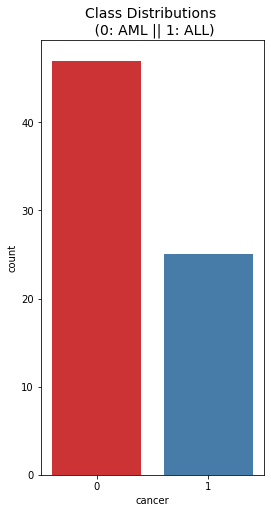

In [12]:
plt.figure(figsize=(4,8))
colors = ["AML", "ALL"]
sns.countplot('cancer', data=Data, palette = "Set1")
plt.title('Class Distributions \n (0: AML || 1: ALL)', fontsize=14)

We can clearly see that the labels are not balanced and we need to balance them before building our classification models.

In [13]:
#X -> matrix of independent variable
#y -> vector of dependent variable
X, y = Data.drop(columns=["cancer"]), Data["cancer"]

In [14]:
X

,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,patient
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,511,-125,389,-37,793,329,36,191,-37,1
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,837,-36,442,-17,782,295,11,76,-14,2
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,1199,33,168,52,1138,777,41,228,-41,3
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,835,218,174,-110,627,170,-50,126,-91,4
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,649,57,504,-26,250,314,14,56,-25,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-154,-136,49,180,-257,-273,141,-123,52,878,...,540,13,1075,-45,524,249,40,-68,-1,68
68,-79,-118,-30,68,-110,-264,-28,-61,40,-217,...,617,-34,738,11,742,234,72,109,-30,69
69,-55,-44,12,129,-108,-301,-222,-133,136,320,...,318,35,241,-66,320,174,-4,176,40,70
70,-59,-114,23,146,-171,-227,-73,-126,-6,149,...,760,-38,201,-55,348,208,0,74,-12,71


In [15]:
y

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Name: cancer, Length: 72, dtype: uint8

### Split the dataset

In [16]:
#split the dataset
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.25, random_state= 0)

### Before feature scaling

In [17]:
#before feature scaling
#X_train = pd.DataFrame(X_train)
#X_train.plot(kind="kde", legend=None)

### Feature scaling

In [18]:
#feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [19]:
X_train.shape

(54, 7130)

### After feature scaling

In [20]:
#after feature scaling
#X_train = pd.DataFrame(X_train)
#X_train.plot(kind="kde", legend=None)

### Dimentionality reduction using Principal Component Analysis(PCA)

38 features explain around 90% of the variance. From 7129 features to 38, not too bad.


<BarContainer object of 38 artists>

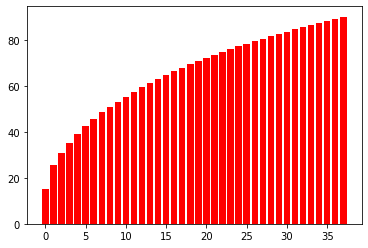

In [21]:
pca = PCA()
pca.fit_transform(X_train)

total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train_pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp,color = 'r')

In [22]:
pca.n_components_ 

38

### 3D plot of first 3 principal components

[]

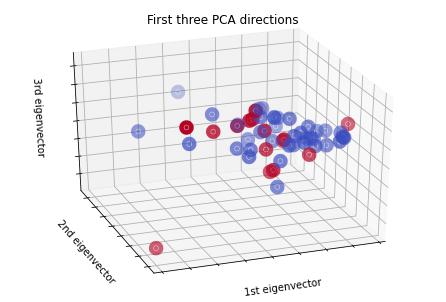

In [23]:
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)

plt.clf()
fig = plt.figure(1, figsize=(10,6))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c = y_train, cmap='coolwarm', linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

### Balacing the lables using SMOTE

In [24]:
from sklearn.utils import resample
from collections import Counter

print("Before Upsampling:-")
print(Counter(y_train))


# Let's use SMOTE to oversample
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_ov, y_train_ov = oversample.fit_resample(X_train_pca,y_train)

print("After Upsampling:-")
print(Counter(y_train_ov))

Before Upsampling:-
Counter({0: 39, 1: 15})
After Upsampling:-
Counter({0: 39, 1: 39})


### Hyperprameter optimization for SVM

In [25]:
# do a grid search
svc_params = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

search = GridSearchCV(SVC(), svc_params, n_jobs=-1, verbose=1)
search.fit(X_train_ov, y_train_ov)

best_accuracy = search.best_score_ #to get best score
best_parameters = search.best_params_ #to get best parameters
# select best svc
best_svc = search.best_estimator_
best_svc

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished


SVC(C=1, kernel='linear')

The accuracy of SVM is 0.7222222222222222

Classification report :
               precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.50      0.67        10

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

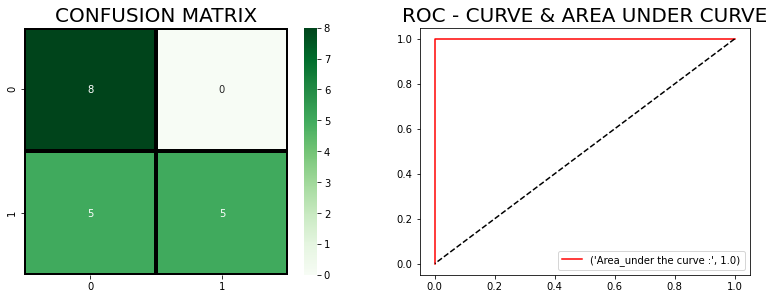

In [26]:
#build SVM model with best parameters
svc_model = SVC(C=1, kernel='linear',probability=True)

svc_model.fit(X_train_ov, y_train_ov)

prediction=svc_model.predict(X_test_pca)

acc_svc = accuracy_score(prediction,y_test)
print('The accuracy of SVM is', acc_svc)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True, cmap='Greens', fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = svc_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

### Hyperprameter optimization for KNN

In [27]:
knn_param = {
    "n_neighbors": [i for i in range(1,30,5)],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": [1, 10, 30],
    "p": [1,2]
}
search = GridSearchCV(KNeighborsClassifier(), knn_param, n_jobs=-1, verbose=1)
search.fit(X_train_ov, y_train_ov)

best_accuracy = search.best_score_ #to get best score
best_parameters = search.best_params_ #to get best parameters
# select best svc
best_knn = search.best_estimator_
best_knn

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:    1.4s finished


KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=1, p=1)

The accuracy of K-NN is 0.6666666666666666

Classification report :
               precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.75      0.60      0.67        10

    accuracy                           0.67        18
   macro avg       0.68      0.68      0.67        18
weighted avg       0.68      0.67      0.67        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

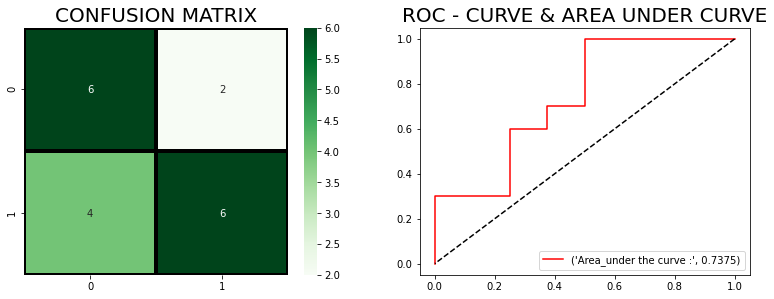

In [28]:
knn_model = KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=6,
                     weights='distance')

knn_model.fit(X_train_ov,y_train_ov)
prediction=knn_model.predict(X_test_pca)

acc_knn = accuracy_score(prediction,y_test)
print('The accuracy of K-NN is', acc_knn)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True, cmap='Greens', fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = knn_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

### Hyperprameter optimization for Logistic regression

In [29]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                 'penalty': ['l1', 'l2']}

log_model = GridSearchCV(estimator=LogisticRegression(solver='liblinear'), 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')
log_model.fit(X_train_ov, y_train_ov)


best_accuracy = log_model.best_score_ #to get best score
best_parameters = log_model.best_params_ #to get best parameters
# select best svc
best_lr = log_model.best_estimator_
best_lr

LogisticRegression(C=0.001, solver='liblinear')

Validation accuracy of Logistic Regression is 0.8333333333333334

Classification report :
               precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.77      1.00      0.87        10

    accuracy                           0.83        18
   macro avg       0.88      0.81      0.82        18
weighted avg       0.87      0.83      0.82        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

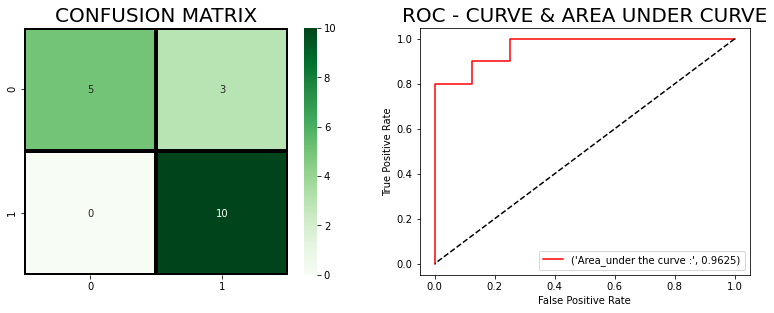

In [30]:
#Logistic Regression
lr_model = LogisticRegression(C=0.001, solver='liblinear')

lr_model.fit(X_train_ov,y_train_ov)

prediction=lr_model.predict(X_test_pca)

acc_log = accuracy_score(prediction,y_test)
print('Validation accuracy of Logistic Regression is', acc_log)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = lr_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

### Hyperprameter optimization for Decision trees

In [31]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4, 5, 6], 'max_depth':[3,4,5,6,7,8]}
decision_search = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

decision_search.fit(X_train_ov, y_train_ov)


best_accuracy = decision_search.best_score_ #to get best score
best_parameters = decision_search.best_params_ #to get best parameters
# select best svc
best_ds = decision_search.best_estimator_
best_ds

Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 8820 out of 8820 | elapsed:   29.0s finished


DecisionTreeClassifier(max_depth=4, max_leaf_nodes=6, random_state=42)

Validation accuracy of Decision Tree is 0.7222222222222222

Classification report :
               precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.50      0.67        10

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

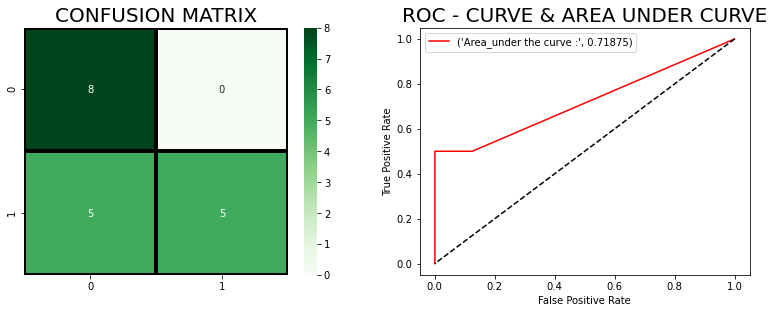

In [32]:
#Decision Tree
ds_model = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=3, random_state=42)

ds_model.fit(X_train_ov,y_train_ov)

prediction=ds_model.predict(X_test_pca)

acc_decision_tree = accuracy_score(prediction,y_test)
print('Validation accuracy of Decision Tree is', acc_decision_tree)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = ds_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

### Hyperprameter optimization for Random forest

In [33]:
# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }

# Create the GridSearchCV object
rf_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid, cv=3, scoring='accuracy')
rf_search.fit(X_train_ov, y_train_ov)

best_accuracy = rf_search.best_score_ #to get best score
best_parameters = rf_search.best_params_ #to get best parameters
# select best svc
best_rf = rf_search.best_estimator_
best_rf

RandomForestClassifier(max_features=0.6, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=70)

Validation accuracy of RandomForest Classifier is 0.7222222222222222

Classification report :
               precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.50      0.67        10

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

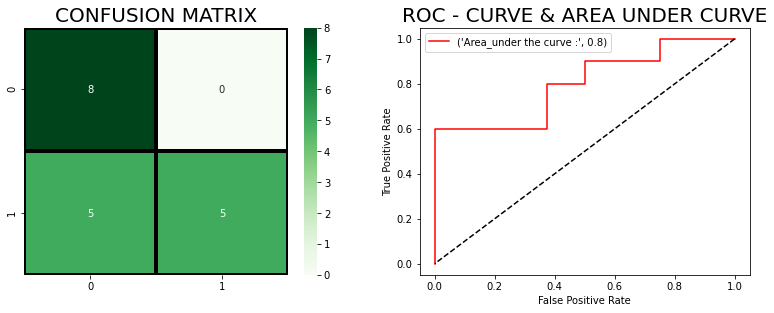

In [34]:
#Random forest
rf_model = RandomForestClassifier(bootstrap=False, max_features=0.6, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=70)

rf_model.fit(X_train_ov,y_train_ov)

prediction=rf_model.predict(X_test_pca)

acc_random_forest = accuracy_score(prediction,y_test)
print('Validation accuracy of RandomForest Classifier is', acc_random_forest)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = rf_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

### Hyperprameter optimization for XGBoost

In [35]:
xgb_grid_params = {'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
               'min_child_weight': [1, 2, 4, 6, 8, 10, 12, 15],
               'n_estimators': [40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
               'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]}

# Create the GridSearchCV object
xgb_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=xgb_grid_params, cv=3, scoring='accuracy')
xgb_search.fit(X_train_ov, y_train_ov)

best_accuracy = xgb_search.best_score_ #to get best score
best_parameters = xgb_search.best_params_ #to get best parameters
# select best svc
best_xgb = xgb_search.best_estimator_
best_xgb

C:\Users\459466\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:20:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:20:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:21:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:21:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:22:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:22:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:23:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:28] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:28] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:24:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:24:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:28] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:28] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:28] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:28] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:25:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:25:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:26:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:27:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:28] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:28] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:28] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:28] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:28:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:29:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:17] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:24] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:26] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:28] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:37] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:39] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:41] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:43] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:50] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:52] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:54] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:56] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:58] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:30:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:30:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:01] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:06] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:08] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:10] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:30] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:32] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:34] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:38] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:40] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:42] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:44] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:45] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:46] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:47] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:48] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:49] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:51] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:53] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:55] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:57] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:31:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:31:59] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:00] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:02] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:03] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:04] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:05] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:07] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:09] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:11] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:12] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:13] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:14] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:15] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:16] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:18] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:19] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:20] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:21] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:22] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:23] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:25] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:27] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:29] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:31] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:33] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[20:32:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:35] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=90, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[20:32:36] WARNING: D:\Build\xgboost\xgboost-1.3.1.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation accuracy of XG Boost is 0.7222222222222222

Classification report :
               precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.50      0.67        10

    accuracy                           0.72        18
   macro avg       0.81      0.75      0.71        18
weighted avg       0.83      0.72      0.71        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

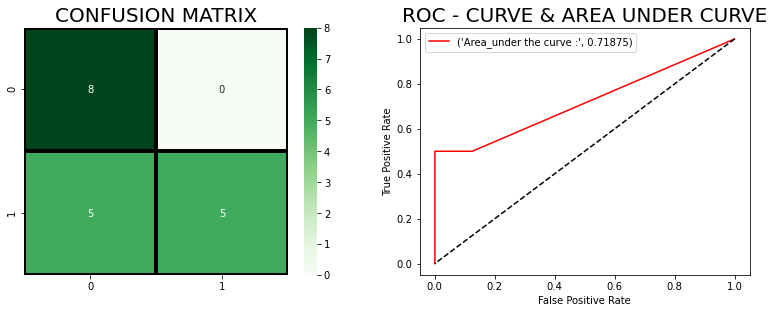

In [36]:
#XB Boost
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=40, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

xgb_model.fit(X_train_ov,y_train_ov)

prediction=xgb_model.predict(X_test_pca)

acc_xgb = accuracy_score(prediction,y_test)
print('Validation accuracy of XG Boost is', acc_xgb)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = xgb_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

Validation accuracy of Naive Bayes is 0.9444444444444444

Classification report :
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.90      0.95        10

    accuracy                           0.94        18
   macro avg       0.94      0.95      0.94        18
weighted avg       0.95      0.94      0.94        18



Text(0.5, 1.0, 'ROC - CURVE & AREA UNDER CURVE')

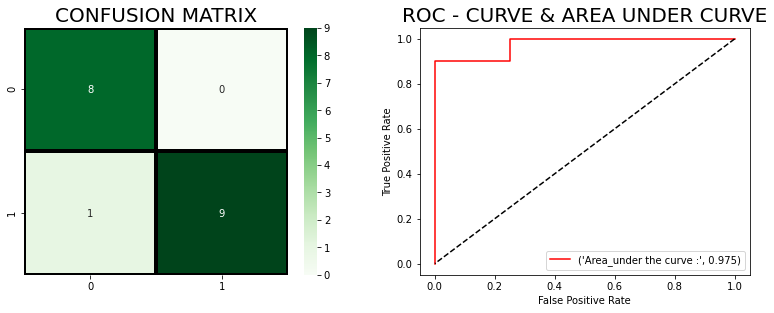

In [37]:
from sklearn.naive_bayes import GaussianNB
#In case of naive Bayes, there isn't a hyper-parameter to tune, so you have nothing to grid search over.
nb_model = GaussianNB()

nb_model.fit(X_train_ov,y_train_ov)

prediction=nb_model.predict(X_test_pca)

acc_nb = accuracy_score(prediction,y_test)
print('Validation accuracy of Naive Bayes is', acc_nb)
print ("\nClassification report :\n",(classification_report(y_test,prediction)))

#Confusion matrix
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cmap="Greens",fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)

#ROC curve and Area under the curve plotting
predicting_probabilites = nb_model.predict_proba(X_test_pca)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)

### Model evaluation

We can now rank our evaluation of all the models to choose the best one for our problem. 

In [38]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Decision Tree',
              'Random Forest', 'XG Boost', 'Naive Bayes'],

    'Score': [acc_svc, acc_knn, acc_log, acc_decision_tree, 
              acc_random_forest, acc_xgb, acc_nb]})
models.sort_values(by='Score', ascending=False)

,Model,Score
6,Naive Bayes,0.944444
2,Logistic Regression,0.833333
0,Support Vector Machines,0.722222
3,Decision Tree,0.722222
4,Random Forest,0.722222
5,XG Boost,0.722222
1,KNN,0.666667


We can observe here Navive Bayes and Logistic regression gave us the maximum accuracy of 94.4% and 83.3% respectively while that of SVM, Descision tree, Random forest and XG Boost remains 72.2%. You can fine tune these models even further to get even better accuracy.